In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import dsa
from dsa import *
from datasets import image
from models import resnet
import pickle

In [2]:
# limit tf to use the first gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-03-29 09:54:02.066060: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-29 09:54:02.978878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [3]:
target_ds, aux_ds = image.load_mnist()

In [8]:
mnist_dsa = {}
log = {}

for split in [4]:
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet(split=split, act="softmax", units=10)
    mnist_dsa["mnist-split="+str(split)] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log["mnist-split="+str(split)] = mnist_dsa["mnist-split="+str(split)].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.sparse_categorical_crossentropy,
        batch_size=64,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.0001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.0001,
        lr_c=0.0001,
        iter_d=1,   # the number of iterations to train the decoder on auxiliary data
        w=500.,
        flatten=False,
        verbose=True,
        log_freq=100)

======Split level is 4======
Iteration 100, average attack MSE: 0.4597578603029251
Iteration 200, average attack MSE: 0.34770307123661043
Iteration 300, average attack MSE: 0.32684107005596164
Iteration 400, average attack MSE: 0.325066924393177
Iteration 500, average attack MSE: 0.2968482613563538
Iteration 600, average attack MSE: 0.2869445767998695
Iteration 700, average attack MSE: 0.2866787973046303
Iteration 800, average attack MSE: 0.26629484370350837
Iteration 900, average attack MSE: 0.25804690539836883
Iteration 1000, average attack MSE: 0.26580711975693705
Iteration 1100, average attack MSE: 0.27476069226861
Iteration 1200, average attack MSE: 0.2752885255217552
Iteration 1300, average attack MSE: 0.2751437890529633
Iteration 1400, average attack MSE: 0.26472644701600073
Iteration 1500, average attack MSE: 0.2574318967759609
Iteration 1600, average attack MSE: 0.25240830078721044
Iteration 1700, average attack MSE: 0.2656737567484379
Iteration 1800, average attack MSE: 0.254

In [6]:
mnist_dsa = {}
log = {}

for split in [2,3,4]:
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet(split=split, class_num=10)
    mnist_dsa["mnist-split="+str(split)] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log["mnist-split="+str(split)] = mnist_dsa["mnist-split="+str(split)].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        batch_size=64,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.0001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.0001,
        lr_c=0.0001,
        iter_d=20,   # the number of iterations to train the decoder on auxiliary data
        w=500.,
        verbose=True,
        log_freq=200)

======Split level is 2======
Iteration 200, average attack MSE: 0.1280130325257778
Iteration 400, average attack MSE: 0.02179331289138645
Iteration 600, average attack MSE: 0.01191164000891149
Iteration 800, average attack MSE: 0.008949216036126018
Iteration 1000, average attack MSE: 0.007700018128380179
Iteration 1200, average attack MSE: 0.007211551703512668
Iteration 1400, average attack MSE: 0.0070256846700795
Iteration 1600, average attack MSE: 0.006722810517530888
Iteration 1800, average attack MSE: 0.008797605154104531
Iteration 2000, average attack MSE: 0.009489241586998105
Iteration 2200, average attack MSE: 0.006510372974444181
Iteration 2400, average attack MSE: 0.009999608627986163
Iteration 2600, average attack MSE: 0.00726060714572668
Iteration 2800, average attack MSE: 0.0073245260026305915
Iteration 3000, average attack MSE: 0.006571760466322303
Iteration 3200, average attack MSE: 0.007516681235283613
Iteration 3400, average attack MSE: 0.00617493376834318
Iteration 360

In [55]:
with open('log/mnist-all.pkl', 'wb') as f:
    pickle.dump(log, f)

tf.Tensor(0.36145476, shape=(), dtype=float32)


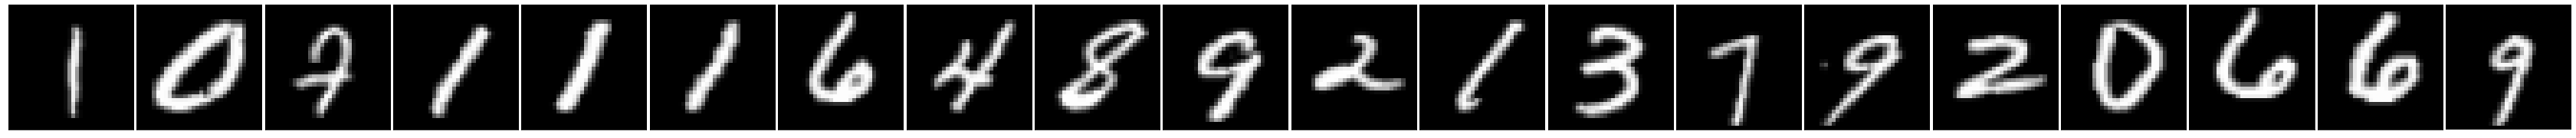

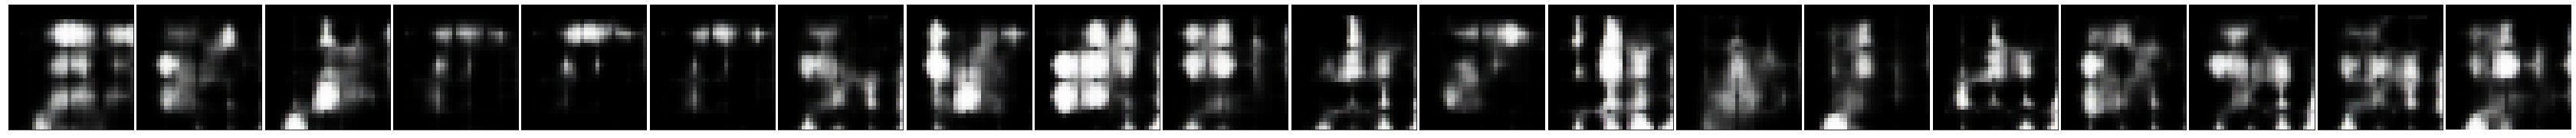

In [12]:
imgs = np.array([x[0].numpy() for x in target_ds.take(20)])

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)

for split in [4]:
#     flattened_z = mnist_dsa["mnist-split="+str(split)].f(imgs, training=False).numpy().reshape((len(imgs), mnist_dsa["mnist-split="+str(split)].flattened_inter_dim))
    mse, rec_res = mnist_dsa["mnist-split="+str(split)].attack_examples(imgs)
    fig = plot(rec_res)
    print(mse)

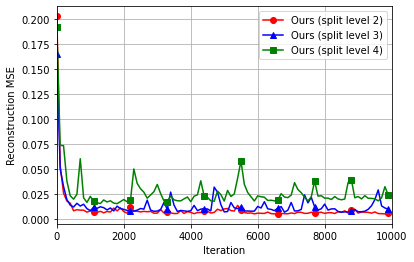

In [72]:
with open('log/mnist-all.pkl', 'rb') as f:
    log = pickle.load(f)

from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 100
# plt.yscale('logit')
plt.xlim([0,10000])
# plt.ylim([0.00, 0.20])
plt.grid()
sampled_log_2 = [sum(log["mnist-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=2"][:,0])/log_freq))]
sampled_log_3 = [sum(log["mnist-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["mnist-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(10000/log_freq))]
plt.plot(ran, sampled_log_2, 'ro-', ran, sampled_log_3, 'b^-', ran, sampled_log_4, 'gs-', markevery=11)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend(["Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/mnist-all.pdf", bbox_inches='tight')